In [ ]:
import shap
import torch
import yaml
from argparse import Namespace
import numpy as np
import pandas as pd
import time
from data_prepare.data_loader import PropertyPredictionDataModule
from data_prepare.tokenizer import MolTranBertTokenizer
from model.layers.main_layer import LightningModule
from fast_transformers.masking import LengthMask as LM
import matplotlib.pyplot as plt
from sklearn import linear_model

def prepare_data(model_name):

     with open(f'Pretrained MoLFormer/hparams/{model_name}.yaml', 'r') as f:
        config = Namespace(**yaml.safe_load(f))
        
        # prepare data:
        data_module = PropertyPredictionDataModule(config)
        data_module.setup()
        data_module.prepare_data()

        # data all loader
        train_loader = data_module.train_dataloader()
        test_loader = data_module.val_dataloader()[1]

        return test_loader,train_loader

def prepare_model(model_name):
        
        with open(f'Pretrained MoLFormer/hparams/{model_name}.yaml', 'r') as f:
        
            config = Namespace(**yaml.safe_load(f))

            tokenizer = MolTranBertTokenizer('bert_vocab.txt')

            ckpt = f'Pretrained MoLFormer/checkpoints/{model_name}.ckpt'

            model = LightningModule(config, tokenizer).load_from_checkpoint(ckpt, strict=False,config=config, tokenizer=tokenizer,vocab=len(tokenizer.vocab))

            # Check for GPU availability
            device = torch.device('cuda')
            model = model.to(device)  # Move model to GPU if available
            model.eval()
            
            return model

model_name = 'ATT_FULL_A0'
model = prepare_model(model_name)
model.eval()


def predict(batch):
    with torch.no_grad():

        idx = batch[0]# idx
        mask = batch[1]# mask
        m_z = batch[2] # m/z
        adduct = batch[3] # adduct
        ecfp = batch[4] # ecfp
        device = "cuda"
        idx, mask, m_z, adduct, ecfp,_ = [x.to(device) for x in batch]
        
        token_embeddings = model.tok_emb(idx) # each index maps to a (learnable) vector
        x = model.drop(token_embeddings)
        x = model.blocks(x, length_mask=LM(mask.sum(-1)))
        token_embeddings = x
        _,pred = model.aggre(x, m_z, adduct, ecfp, mask)
        print(pred.shape)
        pred = model.net.get_layerfc3(pred)

    return pred.cpu().detach().numpy()

def print_accuracy(f,x_test,y_test):
    print(f"Root mean squared test error = {np.sqrt(np.mean((f(x_test) - y_test) ** 2))}")
    time.sleep(0.5)  # to let the print get out before any progress bars


Initializing an instance of Head
Initializing an instance of Aggre_Attention
Initializing an instance of Head
Initializing an instance of Aggre_Attention


In [ ]:

if __name__ == '__main__':
    emb_output = []
    truth = []
    test_dataloader, train_dataloader = prepare_data(model_name)

    for batch in train_dataloader:
    
        pred = predict(batch)
        emb_output.extend(pred)
        truth.extend(batch[-1].cpu().detach().numpy())
    x_train = np.stack(emb_output)
    y_train = np.stack(truth)


    test_pred = []
    test_y = []
    for test_batch in test_dataloader:

        pred = predict(test_batch)
        test_pred.extend(pred)
        test_y.extend(test_batch[-1].cpu().detach().numpy()) 
    test_pred  = np.stack(test_pred)
    test_y  = np.stack(test_y)


    print(f'test_pred shape is {test_pred.shape}')
    print(f'test_y.shape is {test_pred.shape}')

arr = np.arange(test_pred.shape[1])
split_arr = np.array_split(arr, 4)
m = 32
result_index= np.concatenate([chunk[:m] for chunk in split_arr]) # 取每份的前m个元素
test_pred = test_pred[:,result_index]
x_train = x_train[:,result_index]
print(x_train.shape)

Inside prepare_dataset
Length of dataset: 3917
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3917 entries, 0 to 3916
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AllCCS ID  3917 non-null   object 
 1   Name       3917 non-null   object 
 2   smiles     3917 non-null   object 
 3   Formula    3917 non-null   object 
 4   Adduct     3917 non-null   int64  
 5   m/z        3917 non-null   float64
 6   CCS        3917 non-null   float64
 7   Input      3917 non-null   object 
 8   ecfp       3917 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 306.0+ KB
adduct max is :9
Length of dataset: 558
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 558 entries, 0 to 557
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AllCCS ID  558 non-null    object 
 1   Name       5

Root mean squared test error = 4.703164577484131


  0%|          | 0/128 [00:00<?, ?it/s]

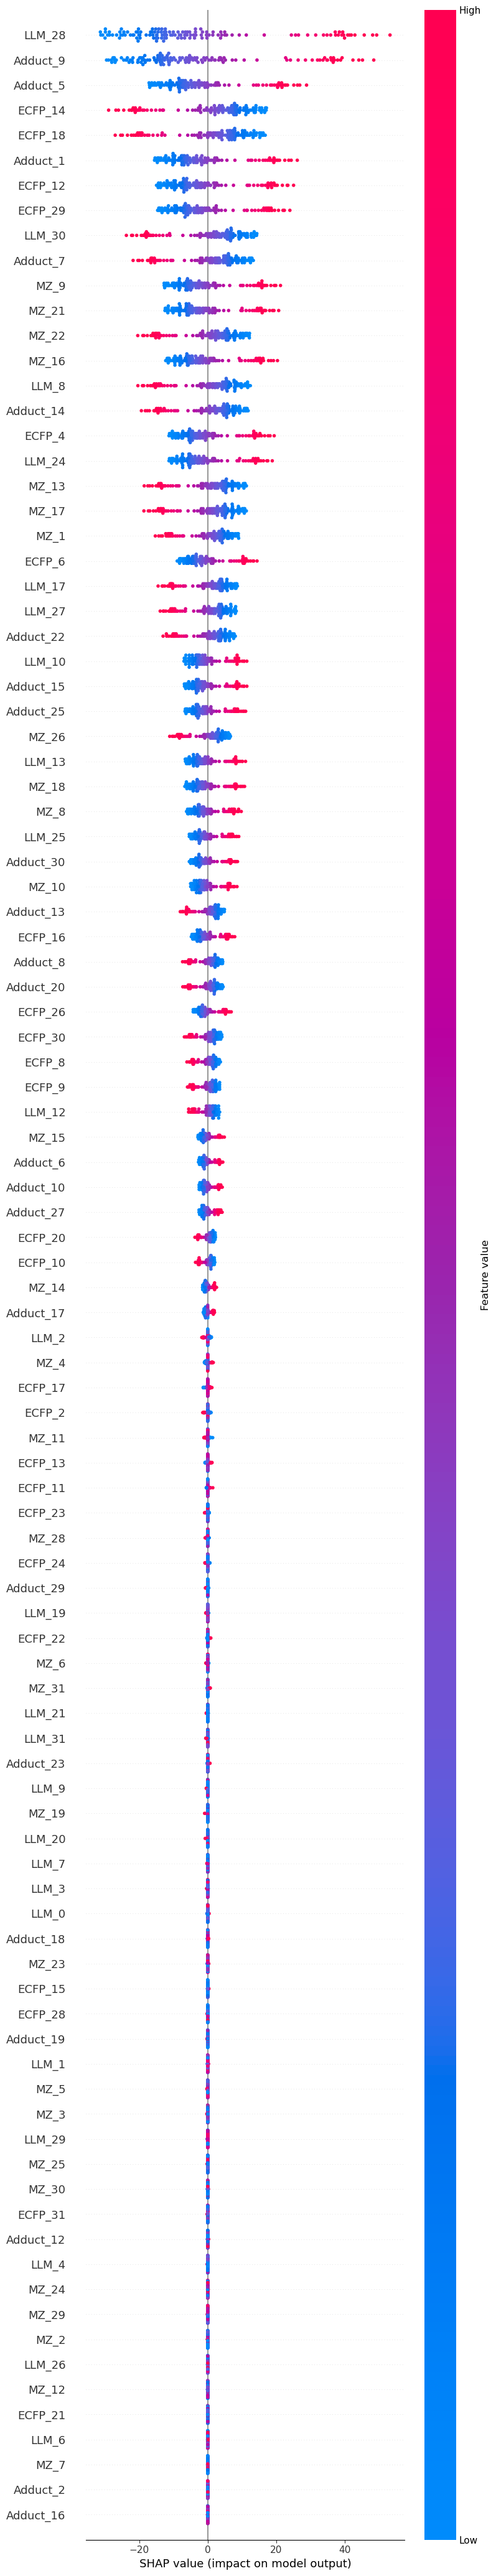

In [27]:
lin_regr = linear_model.LinearRegression()
lin_regr.fit(x_train, y_train)  
print_accuracy(lin_regr.predict,test_pred,test_y)

f_size = 32
features_name = [f"{prefix}_{n}" for prefix in ["LLM", "MZ", "Adduct","ECFP"] for n in range(f_size)]

X_train_summary = shap.kmeans(x_train, 4)
ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)
# ex = shap.KernelExplainer(lin_regr.predict, x_train[:200])  full shap
shap_index = [i for i in range(f_size*4)]
shap_values = ex.shap_values(test_pred[shap_index])

shap.initjs()
shap.summary_plot(shap_values, test_pred[:f_size*4],features_name,max_display=100)

In [ ]:
# 1. 确定需要显示的特征索引
selected_indices = list(range(10)) + list(range(767, 777)) + list(range(1536, 1546))  # 前10个和第30-40个特征

# 2. 筛选 SHAP 值和特征名称
shap_values_selected = shap_values[:, selected_indices]  # 筛选 SHAP 值
features_name_selected = [features_name[i] for i in selected_indices]  # 筛选特征名称

# 3. 筛选测试数据的特征列
test_pred_selected = test_pred[:200, selected_indices]  # 筛选相同的特征列

# 4. 绘制 SHAP 摘要图
shap.summary_plot(
    shap_values_selected,  # 筛选后的 SHAP 值
    test_pred_selected,    # 筛选后的测试数据
    feature_names=features_name_selected,  # 筛选后的特征名称
    max_display=len(selected_indices),  # 显示所有筛选后的特征,
    plot_size=(8, 6)
)

In [ ]:
shap.summary_plot(shap_values, test_pred[:200],features_name[:200],max_display=20)

In [ ]:
shap.save_html("force_plot_200.html",shap.force_plot(ex.expected_value, shap_values[0:200, :], test_pred[0:200, :]))

In [ ]:
from shap.maskers import Independent
# 创建一个 masker
masker = Independent(test_pred)  # X_train 是训练数据
explainer = shap.Explainer(lin_regr.predict,masker)
shap_values= explainer(test_pred[:200])

In [ ]:
shap_values.feature_names =features_name
shap.plots.scatter(shap_values[:,1], color=shap_values,dot_size=32,show=False)  # 关闭自动显示，便于后续调整

# 2. 获取当前画布并修改尺寸
current_fig = plt.gcf()
current_fig.set_size_inches(5, 8)  # 设置宽度和高度（单位：英寸）

# 3. 手动显示图像
plt.show()
                   

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

shap_values.feature_names =features_name
# 自定义全蓝色颜色条（从浅蓝到深蓝）
colors = [ (0.0, 0.533, 0.980),(0.008, 0.435, 0.925)]  # RGB 格式
cmap_blue = LinearSegmentedColormap.from_list('custom_blue', colors)


shap.plots.scatter(shap_values[:,1], color=shap_values[:,40:],cmap=cmap_blue,dot_size=32,show=False)
# 2. 获取当前画布并修改尺寸
current_fig = plt.gcf()
current_fig.set_size_inches(5, 8)  # 设置宽度和高度（单位：英寸）

# 3. 手动显示图像
plt.show()

In [ ]:
shap.plots.bar(shap_values[:,:10])

In [ ]:
clustering = shap.utils.hclust(test_pred, test_y)

In [ ]:
# shap.plots.bar(shap_values, clustering=clustering,clustering_cutoff=0.8)
shap.plots.bar(shap_values,max_display=128)

In [ ]:
shap.plots.waterfall(shap_values[10])

In [ ]:
shap.save_html("force_plot_llm.html",shap.plots.force(shap_values[10]))